<a href="https://colab.research.google.com/github/8sheeta8/2025_Capstone_DDoS-Botnet/blob/main/CNN%2BTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================
# 1. 필요한 라이브러리 임포트
# ==========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models
import tensorflow as tf

print("[1단계 완료] 라이브러리 임포트 완료")

[1단계 완료] 라이브러리 임포트 완료


In [ ]:
# ==========================
# 2. 데이터 불러오기 및 통합
# ==========================
csv_files = [
    '/content/Tuesday-WorkingHours.pcap_ISCX.csv',
    '/content/Wednesday-workingHours.pcap_ISCX.csv',
    '/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    '/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'
]

full_data = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
full_data.columns = full_data.columns.str.strip()  # 컬럼명 공백 제거

print("[2단계 완료] 데이터 통합 완료")
print("전체 데이터 shape:", full_data.shape)

[2단계 완료] 데이터 통합 완료
전체 데이터 shape: (2300825, 79)


In [ ]:
print(full_data.columns)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [ ]:
csv_files = [
    '/content/Tuesday-WorkingHours.pcap_ISCX.csv',
    '/content/Wednesday-workingHours.pcap_ISCX.csv',
    '/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    '/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    '/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'
]

for file in csv_files:
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()   # ★ 컬럼명 앞뒤 공백 제거 ★
    labels = df['Label'].unique()
    print(f"\n{file} 파일에 포함된 라벨 종류:")
    print(labels)



/content/Tuesday-WorkingHours.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'FTP-Patator' 'SSH-Patator']

/content/Wednesday-workingHours.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']

/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']

/content/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'Infiltration']

/content/Friday-WorkingHours-Morning.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'Bot']

/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'DDoS']

/content/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv 파일에 포함된 라벨 종류:
['BENIGN' 'PortScan']


In [ ]:
# ==========================
# 3. 데이터 전처리
# ==========================

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# ==========================
# 추가 - 라벨 통합 전 원본 복사
# ==========================
full_data_label_copy = full_data['Label'].copy()

# ==========================
# 기존 코드 (절대 수정 안 함)
# ==========================
# 불필요한 컬럼 제거
drop_columns = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Timestamp']
full_data = full_data.drop(columns=[col for col in drop_columns if col in full_data.columns], errors='ignore')

# 결측치 제거
full_data = full_data.replace([np.inf, -np.inf], np.nan)
full_data = full_data.dropna()

# Label 통합
def map_label(label):
    label = str(label)
    if 'Web Attack' in label:
        return 'Web Attack'
    elif 'DoS' in label:
        return 'DoS'
    elif 'Heartbleed' in label:
        return 'Heartbleed'
    elif 'Bot' in label:
        return 'Botnet'
    elif 'DDoS' in label:
        return 'DDoS'
    elif 'Patator' in label:
        return 'Patator'
    elif 'PortScan' in label:
        return 'PortScan'
    elif 'Infiltration' in label:
        return 'Infiltration'
    elif label == 'BENIGN':
        return 'Normal'
    else:
        return 'Other'

full_data['Label'] = full_data['Label'].apply(map_label)

# Label 인코딩
labelencoder = LabelEncoder()
full_data['Label'] = labelencoder.fit_transform(full_data['Label'])

# 피처와 라벨 분리
X = full_data.drop('Label', axis=1)
y = full_data['Label']

# 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("[3단계 완료] 전처리 완료")
print("특성 수:", X_scaled.shape[1])



[3단계 완료] 전처리 완료
특성 수: 77


In [ ]:
# ==========================
# 4. SMOTE로 클래스 불균형 처리
# ==========================
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)
X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

print("[4단계 완료] SMOTE 완료")
print("SMOTE 이후 데이터 shape:", X_resampled.shape)


[4단계 완료] SMOTE 완료
SMOTE 이후 데이터 shape: (13934712, 77)


In [ ]:

# ==========================
# 추가 - 라벨 확인용 출력
# ==========================
class_to_labels = defaultdict(set)

def map_label_check(label):
    label = str(label)
    if 'Web Attack' in label:
        class_to_labels['Web Attack'].add(label)
    elif 'DoS' in label:
        class_to_labels['DoS'].add(label)
    elif 'Heartbleed' in label:
        class_to_labels['Heartbleed'].add(label)
    elif 'Bot' in label:
        class_to_labels['Botnet'].add(label)
    elif 'DDoS' in label:
        class_to_labels['DDoS'].add(label)
    elif 'Patator' in label:
        class_to_labels['Patator'].add(label)
    elif 'Infiltration' in label:
        class_to_labels['Infiltration'].add(label)
    elif 'PortScan' in label:
        class_to_labels['PortScan'].add(label)
    elif label == 'BENIGN':
        class_to_labels['Normal'].add(label)
    else:
        class_to_labels['Other'].add(label)

# 복사한 원본 라벨 기준으로 확인
full_data_label_copy.apply(map_label_check)

print("\n=== 클래스별 원래 라벨 모음 ===")
for cls, labels in class_to_labels.items():
    print(f"클래스: {cls}")
    for l in sorted(labels):
        print(f"  - {l}")


=== 클래스별 원래 라벨 모음 ===
클래스: Normal
  - BENIGN
클래스: Patator
  - FTP-Patator
  - SSH-Patator
클래스: DoS
  - DDoS
  - DoS GoldenEye
  - DoS Hulk
  - DoS Slowhttptest
  - DoS slowloris
클래스: Heartbleed
  - Heartbleed
클래스: Web Attack
  - Web Attack � Brute Force
  - Web Attack � Sql Injection
  - Web Attack � XSS
클래스: Infiltration
  - Infiltration
클래스: Botnet
  - Bot
클래스: PortScan
  - PortScan


In [ ]:
# ==========================
# 5. 클래스별 균형 샘플링 (300개씩)
# ==========================
sampled_X = []
sampled_y = []

labels = np.unique(y_resampled)

for label in labels:
    indices = np.where(y_resampled == label)[0]
    if len(indices) >= 10000:
        selected = np.random.choice(indices, 10000, replace=False)
    else:
        selected = np.random.choice(indices, len(indices), replace=False)
    sampled_X.append(X_resampled[selected])
    sampled_y.append(y_resampled[selected])

X_sampled = np.vstack(sampled_X)
y_sampled = np.hstack(sampled_y)

print("샘플링 후 데이터 shape:", X_sampled.shape)
print("클래스별 데이터 개수:", np.bincount(y_sampled))



샘플링 후 데이터 shape: (80000, 77)
클래스별 데이터 개수: [10000 10000 10000 10000 10000 10000 10000 10000]


In [ ]:
# ==========================
# 6. 학습/테스트 데이터 분리
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled
)

print("[6단계 완료] 학습/테스트 분리 완료")
print("Train 데이터:", X_train.shape)
print("Test 데이터:", X_test.shape)


[6단계 완료] 학습/테스트 분리 완료
Train 데이터: (64000, 77)
Test 데이터: (16000, 77)


In [ ]:

# ==========================
# 7. CNN + Transformer 모델 구축
# ==========================
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

input_shape = (X_train.shape[1], 1)
num_classes = len(np.unique(y_train))

inputs = layers.Input(shape=input_shape)
x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)

attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention_output = layers.Add()([x, attention_output])
attention_output = layers.LayerNormalization()(attention_output)

ffn_output = layers.Dense(128, activation='relu')(attention_output)
ffn_output = layers.Dense(64, activation='relu')(ffn_output)
ffn_output = layers.Add()([attention_output, ffn_output])
ffn_output = layers.LayerNormalization()(ffn_output)

x = layers.GlobalAveragePooling1D()(ffn_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print("[7단계 완료] 모델 구축 완료")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 77, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 77, 64)    │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 77, 64)    │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 77, 64)    │     66,368 │ conv1d_3[0][0],   │
│ (MultiHeadAttentio… │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 77, 64)    │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 77, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 77, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 77, 64)    │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 77, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 77, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │        520 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 112,904 (441.03 KB)

 Trainable params: 112,904 (441.03 KB)

 Non-trainable params: 0 (0.00 B)

[7단계 완료] 모델 구축 완료


In [ ]:
# ==========================
# 8. 모델 학습
# ==========================
history = model.fit(
    X_train_reshaped, y_train,
    epochs=20, batch_size=64,
    validation_split=0.2,
    #callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

print("[8단계 완료] 모델 학습 완료")

Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 75s 93ms/step - accuracy: 0.9470 - loss: 0.1631 - val_accuracy: 0.9525 - val_loss: 0.1431
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 75s 93ms/step - accuracy: 0.9487 - loss: 0.1582 - val_accuracy: 0.9592 - val_loss: 0.1309
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 74s 93ms/step - accuracy: 0.9532 - loss: 0.1460 - val_accuracy: 0.9568 - val_loss: 0.1328
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 75s 94ms/step - accuracy: 0.9532 - loss: 0.1477 - val_accuracy: 0.9599 - val_loss: 0.1149
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 75s 94ms/step - accuracy: 0.9514 - loss: 0.1500 - val_accuracy: 0.9611 - val_loss: 0.1163
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 75s 94ms/step - accuracy: 0.9581 - loss: 0.1340 - val_accuracy: 0.9591 - val_loss: 0.1309
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 75s 94ms/step - accuracy: 0.9585 - loss: 0.1270 - val_accuracy: 0.9627 - val_loss: 0.1140
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 75s 94ms/step - accuracy: 0.9586 - loss: 0.1259 - 

500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step

Classification Report:
              precision    recall  f1-score   support

      Botnet       0.98      1.00      0.99      2000
         DoS       0.93      0.99      0.96      2000
  Heartbleed       1.00      1.00      1.00      2000
Infiltration       0.99      0.99      0.99      2000
      Normal       0.97      0.85      0.90      2000
     Patator       0.90      1.00      0.95      2000
    PortScan       0.98      0.99      0.99      2000
  Web Attack       0.99      0.91      0.94      2000

    accuracy                           0.97     16000
   macro avg       0.97      0.97      0.97     16000
weighted avg       0.97      0.97      0.97     16000



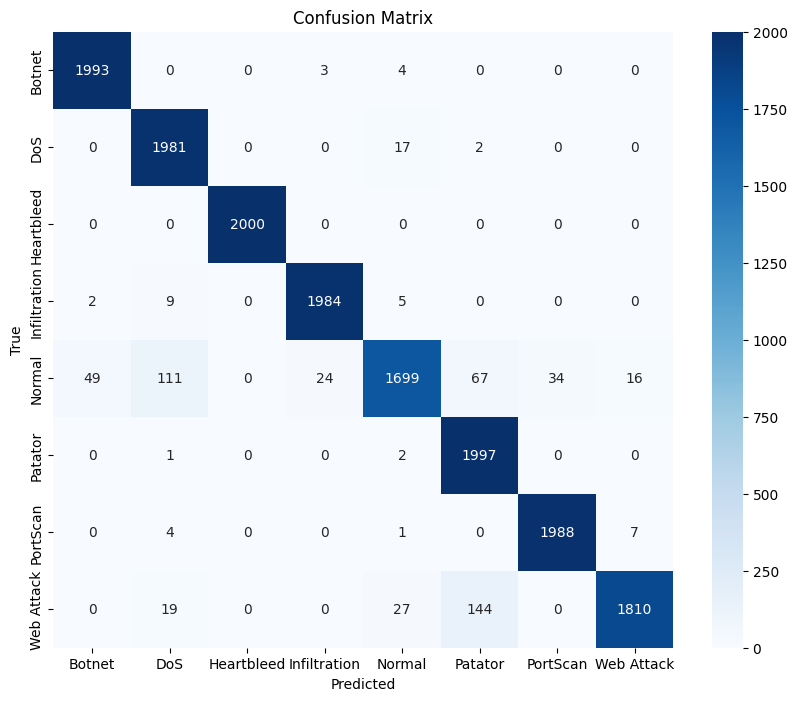

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 9. 성능 평가
# ==========================

# 예측 수행
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# 현재 테스트셋에 존재하는 클래스 인덱스를 기준으로 라벨 이름 재정렬
label_indices = np.unique(y_test)
label_names = labelencoder.inverse_transform(label_indices)

# 1) Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_names))

# 2) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# ==========================
# 기존 모델 저장
# ==========================

# 학습 완료된 모델 저장
model.save('model_baseline.keras')
print("[기존 모델 저장 완료]: model_baseline(1).keras")

[기존 모델 저장 완료]: model_baseline(1).keras


하드 학습

In [ ]:
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ==========================
# 1. 기존 모델 불러오기
# ==========================
from tensorflow.keras.models import load_model
model = load_model('model_baseline.keras')  # 기존 모델 저장된 파일명

print("[기존 모델 로드 완료]")

# ==========================
# 2. 기존 모델로 학습 데이터 예측
# ==========================
y_pred_train = np.argmax(model.predict(X_train_reshaped), axis=1)

# ==========================
# 3. 오탐 데이터(Wrong Prediction) 추출
# ==========================
wrong_indices = np.where(y_pred_train != y_train)[0]
easy_indices = np.where(y_pred_train == y_train)[0]

print(f"[오탐 데이터 개수]: {len(wrong_indices)}개")
print(f"[정확히 예측한 데이터 개수]: {len(easy_indices)}개")

# ==========================
# 4. 하드 데이터셋 구성
# ==========================
X_hard = X_train[wrong_indices]
y_hard = y_train[wrong_indices]

# 하드 데이터 2배 복제
X_hard_augmented = np.concatenate([X_hard, X_hard])
y_hard_augmented = np.concatenate([y_hard, y_hard])

# Easy 데이터
X_easy = X_train[easy_indices]
y_easy = y_train[easy_indices]

# 최종 학습 데이터
X_train_final = np.concatenate([X_easy, X_hard_augmented])
y_train_final = np.concatenate([y_easy, y_hard_augmented])

# 셔플
X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)

print("[하드마이닝 완료]")
print("최종 학습 데이터 shape:", X_train_final.shape)

# 3D reshape
X_train_final_reshaped = np.expand_dims(X_train_final, axis=2)

# ==========================
# 5. focal loss 정의
# ==========================
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
        y_pred = tf.clip_by_value(y_pred, keras.backend.epsilon(), 1. - keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

print("[Focal Loss 정의 완료]")

# ==========================
# 6. 모델 복사
# ==========================
# 기존 모델 복사 (가중치는 초기화)
input_shape = (X_train.shape[1], 1)

inputs = layers.Input(shape=input_shape)
x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)

attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention_output = layers.Add()([x, attention_output])
attention_output = layers.LayerNormalization()(attention_output)

ffn_output = layers.Dense(128, activation='relu')(attention_output)
ffn_output = layers.Dense(64, activation='relu')(ffn_output)
ffn_output = layers.Add()([attention_output, ffn_output])
ffn_output = layers.LayerNormalization()(ffn_output)

x = layers.GlobalAveragePooling1D()(ffn_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

new_model = keras.Model(inputs=inputs, outputs=outputs)

new_model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
print("[새로운 모델 컴파일 완료]")

# ==========================
# 7. 모델 재학습
# ==========================
history = new_model.fit(
    X_train_final_reshaped, y_train_final,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

print("[모델 재학습 완료]")

# ==========================
# 8. 모델 저장
# ==========================
new_model.save('model_hard_focal.keras')
print("[새 모델 저장 완료]")


[기존 모델 로드 완료]
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step
[오탐 데이터 개수]: 2116개
[정확히 예측한 데이터 개수]: 61884개
[하드마이닝 완료]
최종 학습 데이터 shape: (66116, 77)
[Focal Loss 정의 완료]
[새로운 모델 컴파일 완료]
Epoch 1/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 85s 96ms/step - accuracy: 0.4927 - loss: 0.2097 - val_accuracy: 0.8722 - val_loss: 0.0520
Epoch 2/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 79s 95ms/step - accuracy: 0.8376 - loss: 0.0556 - val_accuracy: 0.8764 - val_loss: 0.0389
Epoch 3/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 79s 95ms/step - accuracy: 0.8730 - loss: 0.0423 - val_accuracy: 0.9030 - val_loss: 0.0252
Epoch 4/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 79s 96ms/step - accuracy: 0.8743 - loss: 0.0399 - val_accuracy: 0.9112 - val_loss: 0.0248
Epoch 5/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 79s 95ms/step - accuracy: 0.8890 - loss: 0.0358 - val_accuracy: 0.9003 - val_loss: 0.0304
Epoch 6/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 79s 96ms/step - accuracy: 0.8994 - loss: 0.0287 - val_accuracy: 0.8837 - val_loss: 0.0386
Epoch 7/20
827/827 ━━━━━━━━━━━━━━━━━━━━ 79

[하드마이닝 + Focal Loss 모델] 로드 완료
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step

[Classification Report]
              precision    recall  f1-score   support

      Botnet       0.96      1.00      0.98      2000
         DoS       0.93      0.89      0.91      2000
  Heartbleed       1.00      1.00      1.00      2000
Infiltration       0.98      0.99      0.98      2000
      Normal       0.85      0.80      0.82      2000
     Patator       0.90      0.99      0.94      2000
    PortScan       0.98      0.99      0.98      2000
  Web Attack       0.97      0.92      0.95      2000

    accuracy                           0.95     16000
   macro avg       0.95      0.95      0.95     16000
weighted avg       0.95      0.95      0.95     16000



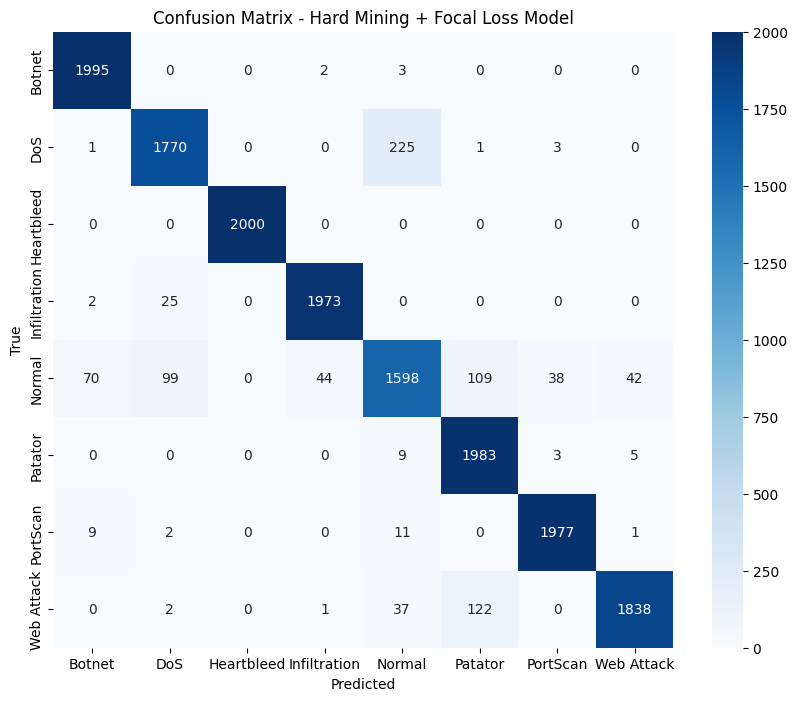

In [ ]:
# ==========================
# 1. 라이브러리 임포트
# ==========================
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# 2. focal_loss_fixed 함수 정의 (저장할 때 사용한 것과 일치해야 함)
# ==========================
def focal_loss_fixed(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes)  # num_classes는 데이터 기준 설정
    y_true = K.squeeze(y_true, axis=1) if len(y_true.shape) == 3 else y_true
    cross_entropy = K.binary_crossentropy(y_true, y_pred)
    weight = alpha * K.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return K.sum(loss, axis=-1)

# ==========================
# 3. 모델 로드 (custom_objects 필수)
# ==========================
model_loaded = load_model('model_hard_focal.keras',
                          custom_objects={'focal_loss_fixed': focal_loss_fixed})
print("[하드마이닝 + Focal Loss 모델] 로드 완료")

# ==========================
# 4. 테스트 데이터 준비 (X_test_reshaped, y_test 사용)
# ==========================
# X_test_reshaped, y_test는 반드시 기존에 준비되어 있어야 합니다.

# ==========================
# 5. 예측 및 평가
# ==========================
y_pred_probs = model_loaded.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n[Classification Report]")
print(classification_report(y_test, y_pred, target_names=labelencoder.classes_))

# ==========================
# 6. Confusion Matrix 시각화
# ==========================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labelencoder.classes_,
            yticklabels=labelencoder.classes_)
plt.title("Confusion Matrix - Hard Mining + Focal Loss Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


FEATURE 추출

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score
from tqdm import tqdm

print("[시작] 클래스별 Permutation Feature Importance 계산")

# 1. 전체 baseline 성능 계산
X_test_flat = X_test_reshaped.squeeze(axis=2)  # (batch_size, feature_dim)
y_pred_baseline = np.argmax(model.predict(X_test_reshaped, verbose=0), axis=1)
baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')

print(f"[Baseline F1] 전체 데이터 기준: {baseline_f1:.4f}")

# 2. 클래스별 인덱스 나누기
class_indices = {i: np.where(y_test == i)[0] for i in np.unique(y_test)}

[시작] 클래스별 Permutation Feature Importance 계산
[Baseline F1] 전체 데이터 기준: 0.9713


In [ ]:
# 3. 클래스별 Feature Importance 계산
feature_importance_per_class = {}
num_features = X_test_flat.shape[1]

for class_label, indices in class_indices.items():
    print(f"\n[진행중] 클래스 {class_label}")

    X_class = X_test_flat[indices]
    y_class = y_test[indices]

    # 클래스별 baseline 성능
    X_class_reshaped = np.expand_dims(X_class, axis=2)
    y_pred_class_baseline = np.argmax(model.predict(X_class_reshaped, verbose=0), axis=1)
    class_baseline_f1 = f1_score(y_class, y_pred_class_baseline, average='macro')

    importances = []

    for feature_idx in tqdm(range(num_features)):
        X_permuted = X_class.copy()
        np.random.shuffle(X_permuted[:, feature_idx])  # Feature 하나만 무작위로 섞음
        X_permuted_reshaped = np.expand_dims(X_permuted, axis=2)

        y_pred_permuted = np.argmax(model.predict(X_permuted_reshaped, verbose=0), axis=1)
        permuted_f1 = f1_score(y_class, y_pred_permuted, average='macro')

        importance = class_baseline_f1 - permuted_f1  # F1-score 하락폭
        importances.append(importance)

    feature_importance_per_class[class_label] = np.array(importances)

    print(f"[완료] 클래스 {class_label} Feature Importance 계산 성공")


[진행중] 클래스 0


100%|██████████| 77/77 [01:39<00:00,  1.29s/it]


[완료] 클래스 0 Feature Importance 계산 성공

[진행중] 클래스 1


100%|██████████| 77/77 [01:37<00:00,  1.27s/it]


[완료] 클래스 1 Feature Importance 계산 성공

[진행중] 클래스 2


100%|██████████| 77/77 [01:38<00:00,  1.28s/it]


[완료] 클래스 2 Feature Importance 계산 성공

[진행중] 클래스 3


100%|██████████| 77/77 [01:39<00:00,  1.30s/it]


[완료] 클래스 3 Feature Importance 계산 성공

[진행중] 클래스 4


100%|██████████| 77/77 [01:42<00:00,  1.33s/it]


[완료] 클래스 4 Feature Importance 계산 성공

[진행중] 클래스 5


100%|██████████| 77/77 [01:41<00:00,  1.32s/it]


[완료] 클래스 5 Feature Importance 계산 성공

[진행중] 클래스 6


100%|██████████| 77/77 [01:41<00:00,  1.32s/it]


[완료] 클래스 6 Feature Importance 계산 성공

[진행중] 클래스 7


100%|██████████| 77/77 [01:39<00:00,  1.29s/it]

[완료] 클래스 7 Feature Importance 계산 성공


In [ ]:
# y_test 라벨 종류와 순서 출력
unique_labels = np.unique(y_test)

# 반드시 실행
print("\n[Label 디코딩 매핑 확인]")
for idx, class_name in enumerate(labelencoder.classes_):
    print(f"{idx}: {class_name}")

# 현재 X 데이터의 컬럼 이름 리스트 출력
current_feature_names = X.columns.tolist()

print("[현재 Feature 목록]")
for idx, feature in enumerate(current_feature_names):
    print(f"{idx}: {feature}")



NameError: name 'y_test' is not defined

In [ ]:
# 4. 클래스별 Top-N Feature 출력
TOP_N = 10

for class_label, importance_scores in feature_importance_per_class.items():
    top_features = np.argsort(importance_scores)[::-1][:TOP_N]
    print(f"\n[클래스 {class_label}] 중요도 Top {TOP_N} Feature 인덱스:")
    print(top_features)
    print(f"중요도 점수: {importance_scores[top_features]}")



[클래스 0] 중요도 Top 10 Feature 인덱스:
[46 37 47 36 52  8 38 39 66 50]
중요도 점수: [0.15614328 0.15474659 0.11961205 0.11700422 0.08898012 0.08793462
 0.08780454 0.08760965 0.08683309 0.08599714]

[클래스 1] 중요도 Top 10 Feature 인덱스:
[38 41 51 11 21  9 50 75 26 15]
중요도 점수: [0.07192726 0.06611424 0.05671938 0.05140628 0.04662817 0.04652809
 0.04513838 0.04227821 0.04213519 0.04085824]

[클래스 2] 중요도 Top 10 Feature 인덱스:
[76 75 74 73 72 71 70 69 68 67]
중요도 점수: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[클래스 3] 중요도 Top 10 Feature 인덱스:
[43 24 52 27 19  5 75 71 46 45]
중요도 점수: [0.35218731 0.30682542 0.30634181 0.30586044 0.30485155 0.30416691
 0.30244928 0.26570238 0.26226834 0.26226834]

[클래스 4] 중요도 Top 10 Feature 인덱스:
[50 72  8 52 19 66 22  6 13 14]
중요도 점수: [0.01762432 0.01667368 0.01649239 0.01584376 0.00125156 0.00108351
 0.0007903  0.00053985 0.00037334 0.00033177]

[클래스 5] 중요도 Top 10 Feature 인덱스:
[43 65 36  8 45 35 47 46 51 14]
중요도 점수: [0.18297288 0.1736181  0.1532713  0.15224117 0.1502095  0.13797317
 0.1316247 